In [2]:
import numpy as np
import cv2, sys
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal

%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)

In [3]:
# load images
img = cv2.imread('images/test.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert the image to grayscale

small = cv2.imread('images/small.png')
small_gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

circle = cv2.imread('images/circle.png')
circle_gray = cv2.cvtColor(circle, cv2.COLOR_BGR2GRAY)

imsize = 512
noise = np.random.rand(imsize, imsize)*255

Text(0.5, 1.0, 'circle.png')

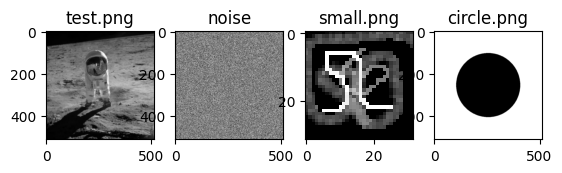

In [4]:
fig, axs = plt.subplots(1, 4)

# display loaded images
axs[0].imshow(gray, cmap='gray')
axs[1].imshow(noise, cmap='gray')
axs[2].imshow(small_gray, cmap='gray')
axs[3].imshow(circle_gray, cmap='gray')

axs[0].set_title("test.png")
axs[1].set_title("noise")
axs[2].set_title("small.png")
axs[3].set_title("circle.png")

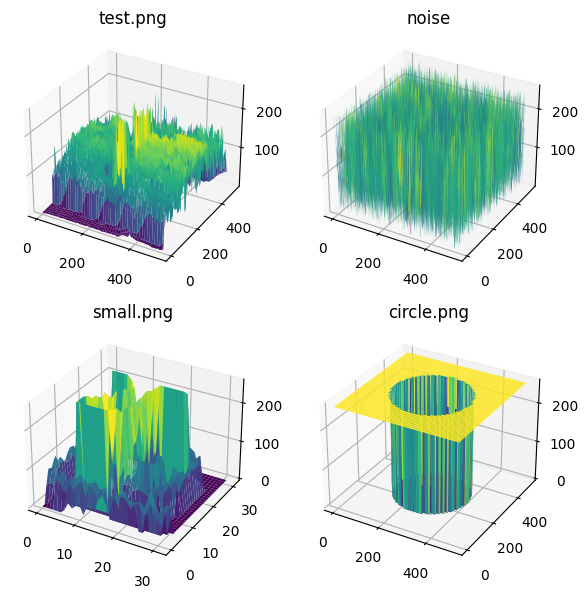

In [5]:
plot_size = 7

# add subpplots
heightmap = plt.figure(figsize=(plot_size, plot_size))
plt1 = heightmap.add_subplot(221, projection='3d')
plt2 = heightmap.add_subplot(222, projection='3d')
plt3 = heightmap.add_subplot(223, projection='3d')
plt4 = heightmap.add_subplot(224, projection='3d')

# different size meshgrids for different images
x1 = y1 = range(imsize)
X1, Y1 = np.meshgrid(x1, y1)
x2 = y2 = range(small.shape[0])
X2, Y2 = np.meshgrid(x2, y2)
x3 = y3 = range(circle.shape[0])
X3, Y3 = np.meshgrid(x3, y3)

# plot surfaces
plt1.plot_surface(X1, Y1, gray, cmap="viridis")
plt2.plot_surface(X1, Y1, noise, cmap="viridis")
plt3.plot_surface(X2, Y2, small_gray, cmap="viridis")
plt4.plot_surface(X3, Y3, circle_gray, cmap="viridis")

plt1.set_title("test.png")
plt2.set_title("noise")
plt3.set_title("small.png")
plt4.set_title("circle.png")

plt.show()

In [6]:
# apply a linear filter to a given neighbourhood
def applyFilter(kernel, image, x, y, mode):

    # set sign needed for kernel access
    if mode == "correlation":
        sign = 1
    elif mode == "convolution":
        sign = -1
    else:
        print("unknown operation")
        sign = 0

    # neighbourhood is of size (2a+1)x(2b+1)
    a = (kernel.shape[0] - 1) // 2
    b = (kernel.shape[1] - 1) // 2
    size = image.shape[0]
    sum = 0
    for i in range(-a, a+1, 1):
        for j in range(-b, b+1, 1):
            value = image[(x + sign * i) % size][(y + sign * j) % size]
            sum += kernel[i][j] * value
    return sum

# filter an entire image
def linearFilter(kernel, image, mode ="correlation"):
    filtered = np.copy(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            filtered[x][y] = applyFilter(kernel, image, x, y, mode)
    return filtered

# return square root of sum of squares for every pixel in two separate images
def rootOfSquares(img1, img2):
    assert img1.shape == img2.shape
    combined = np.copy(img1)
    for x in range(combined.shape[0]):
        for y in range(combined.shape[1]):
            combined[x][y] = np.sqrt(img1[x][y]**2 + img2[x][y]**2)
    return combined

In [7]:
n = 3
kernels = {}

# class for allowing iteration over all instances of the Kernel class
class IterRegistry(type):
    def __iter__(cls):
        return iter(cls._registry)

class Kernel(metaclass=IterRegistry):
    # registry holding all instances of the Kernel class
    _registry = []

    def __init__(self, name, kernel, operation_type="correlation"):
        # add self to registry
        self._registry.append(self)

        self.name = name
        self.kernel = kernel
        self.operation_type = operation_type

    def __str__(self):
        return self.name

In [8]:
# identity filter
kernelI = np.zeros((n, n))
kernelI[(n-1)//2][(n-1)//2] = 1
identity = Kernel("identity", kernelI)

# primitive smoothing filter
kernel_smooth = 1/(n**2) * np.ones((n, n))
smooth = Kernel("smooth", kernel_smooth)

# left shift
kernel_Rshift = np.zeros((n, n))
kernel_Rshift[(n-1)//2][0] = 1
Rshift = Kernel("Rshift", kernel_Rshift)

# primitive sharpening filter
kernel_sharpen = 2 * kernelI - kernel_smooth
sharpen = Kernel("sharpen", kernel_sharpen)

# gaussian blur
def gaussianKernel(size=n, sigma=1):
    """Returns a 2D Gaussian kernel array."""
    gaussian_kernel1d = signal.gaussian(size, std=sigma).reshape(size, 1)
    gaussian_kernel2d = np.outer(gaussian_kernel1d, gaussian_kernel1d)
    normalizing_factor = 1/(2*np.pi)
    return gaussian_kernel2d * normalizing_factor

kernel_gaussian = gaussianKernel(size=n)
gaussian = Kernel("gaussian", kernel_gaussian)

# prewitt's operator
kernel_prewitt_x = np.zeros((3, 3))
kernel_prewitt_x[:,0] = np.ones(3)
kernel_prewitt_x[:,-1] = -np.ones(3)
prewitt_x = Kernel("prewitt_x", kernel_prewitt_x, "convolution")

kernel_prewitt_y = np.zeros((3, 3))
kernel_prewitt_y[0,:] = np.ones(3)
kernel_prewitt_y[-1,:] = -np.ones(3)
prewitt_y = Kernel("prewitt_y", kernel_prewitt_y, "convolution")

# sobel's operator
kernel_sobel_x = np.array([[1,0,-1], [2,0,-2], [1,0,-1]])
sobel_x = Kernel("sobel_x", kernel_sobel_x, "convolution")

kernel_sobel_y = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
sobel_y = Kernel("sobel_y", kernel_sobel_y, "convolution")

# derivative filter
kernel_derivative = np.array([[0,1,0],[1,-4,1],[0,1,0]])
derivative = Kernel("derivative", kernel_derivative)

# laplacian filter
kernel_laplacian = -np.ones((n, n))
kernel_laplacian[(n-1)//2][(n-1)//2] = n**2 - 1
laplacian = Kernel("laplacian", kernel_laplacian)

# add all the kernels to a dict
for kernel in Kernel:
    kernels[kernel.name] = kernel

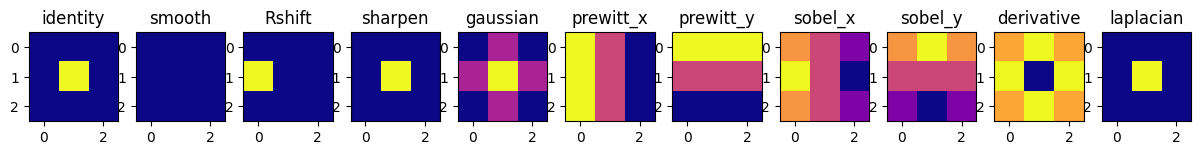

In [9]:
# combine data for all kernels to set a uniform colormap (unused)
combined_data = np.array([kernel.kernel for kernel in Kernel])
_min, _max = np.amin(combined_data), np.amax(combined_data)

plot_size = 15
fig, axs = plt.subplots(1, len(kernels), figsize=(plot_size, plot_size))

colormap = "plasma"

# plot all filter kernels from the dict holding all instances of the Kernel class
i = 0
for key in kernels:
    # axs[i].imshow(kernels[key].kernel, vmin = _min, vmax = _max, cmap = colormap)  <-- normalize colormap across all filter kernels
    axs[i].imshow(kernels[key].kernel, cmap = colormap)
    axs[i].set_title(key)
    i -=- 1

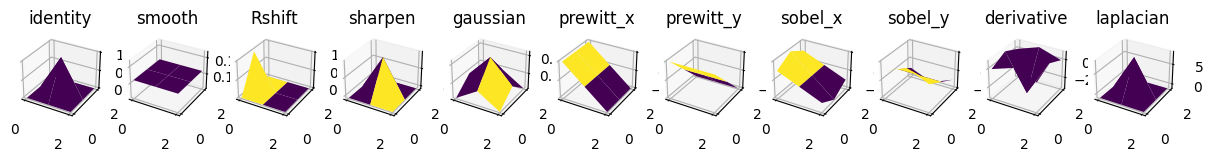

In [10]:
# common meshgrid for the filter kernels
x = y = range(n)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(plot_size, plot_size))

# plot 3d surfaces corresponding to all filter kernels from the dict containing all instances of the Kernel class
axs = []
i = 0
for key in kernels:
    ax = fig.add_subplot(1, len(kernels), i+1, projection='3d')
    axs.append(ax)
    axs[i].plot_surface(X, Y, kernels[key].kernel, cmap="viridis")
    axs[i].set_title(key)
    i -=- 1
plt.show()

In [11]:
# choose an image and apply all the filters
test_image = gray
filtered_images = {}
for key in kernels:
    filtered_images[key] = linearFilter(kernels[key].kernel, test_image, mode=kernels[key].operation_type)

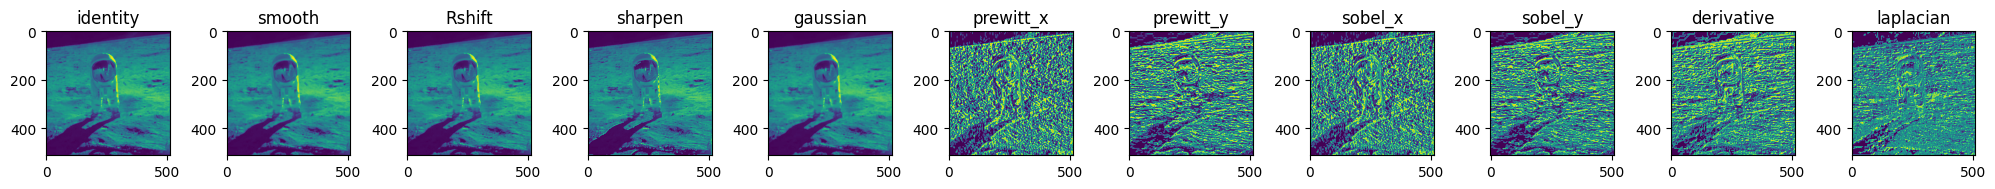

In [12]:
# plot filtered images
plot_size = 20
padding = 1

fig, axs = plt.subplots(1, len(kernels), figsize=(plot_size, plot_size))
fig.tight_layout(pad = padding)
i = 0
for key in filtered_images:
    axs[i].imshow(filtered_images[key], cmap='viridis')
    axs[i].set_title(key)
    i -=- 1

plt.show()

In [13]:
# sinusoidal gratings useful for visualizing Fourier bases
def getSinusoidalGrating(frequency, theta = np.pi/4, limit = 5, density=1001):
    x = np.linspace(-limit, limit, density)
    X, Y = np.meshgrid(x, x)
    grating = np.sin(2 * np.pi * (X * np.cos(theta) + Y * np.sin(theta)) * frequency)
    return grating

def getMagnitudeSpectrum(img):
    # fourier transform with shift for easier plotting
    FT = np.fft.ifftshift(img)
    FT = np.fft.fft2(FT)
    FT = np.fft.fftshift(FT)
    return abs(FT)

def plotFourierGrid(grid):
    grid_x, grid_y = grid.shape[0], grid.shape[1]
    plot_size, padding = 6, 1
    fig, axs = plt.subplots(grid_x * 2, grid_y, figsize=(plot_size, 2*plot_size))
    fig.tight_layout(pad = padding)
    for i in range(grid_x):
        for j in range(grid_y):
            img = grid[i][j]
            magnitude = getMagnitudeSpectrum(img)

            # plotting the original image
            axs[2 * i, j].imshow(img, cmap='gray')
            axs[2 * i, j].set_title("freq={:.2f}, theta={:.2f}".format(frequencies[i], thetas[j]), fontsize=9)

            # plotting the magnitude spectrum
            low_limit = density // 2 - 20
            high_limit = density // 2 + 20
            axs[2 * i + 1, j].axis(xmin=low_limit, xmax=high_limit, ymin=low_limit, ymax=high_limit)
            axs[2 * i + 1, j].set_title("magnitude, {:.2f}, {:.2f}".format(frequencies[i], thetas[j]), fontsize=9)
            axs[2 * i + 1, j].imshow(magnitude, cmap='gray')

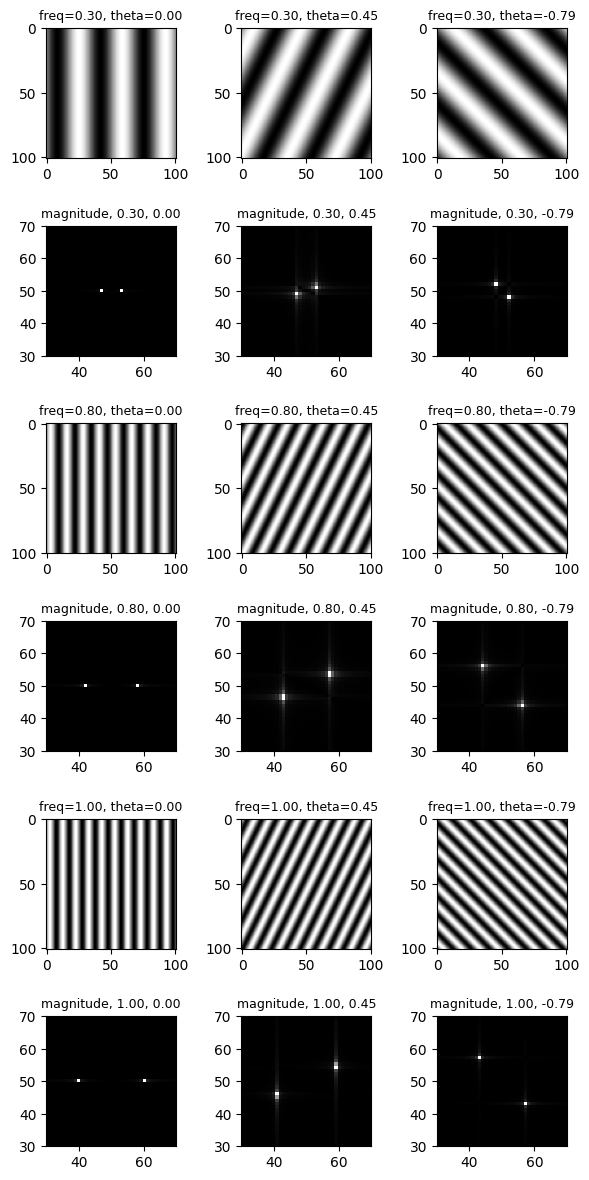

In [14]:
frequencies = np.array([0.3, 0.8, 1])
thetas = np.array([0, np.pi/7, -np.pi/4])
density = 101
grid = np.zeros((len(frequencies), len(thetas), density, density))

for i in range(len(frequencies)):
    for j in range(len(thetas)):
        grid[i][j] = getSinusoidalGrating(frequencies[i], theta=thetas[j], density=density)
plotFourierGrid(grid)